In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Churn_Modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
data = data.drop(["RowNumber","CustomerId","Surname"],axis = 1)

In [9]:
categorical_columns=[col for col in data.columns if data[col].dtype=='O']
categorical_columns

['Geography', 'Gender']

In [10]:
categorical=data[categorical_columns]
categorical.head()

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female


In [11]:
for feature in categorical.columns:
    print('{} has total {} categories \n' .format(feature,len(categorical[feature].value_counts())))

Geography has total 3 categories 

Gender has total 2 categories 



In [12]:
label_encoder = LabelEncoder()

data['Geography']= label_encoder.fit_transform(data['Geography'])
data['Gender']= label_encoder.fit_transform(data['Gender'])

In [13]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


<Axes: >

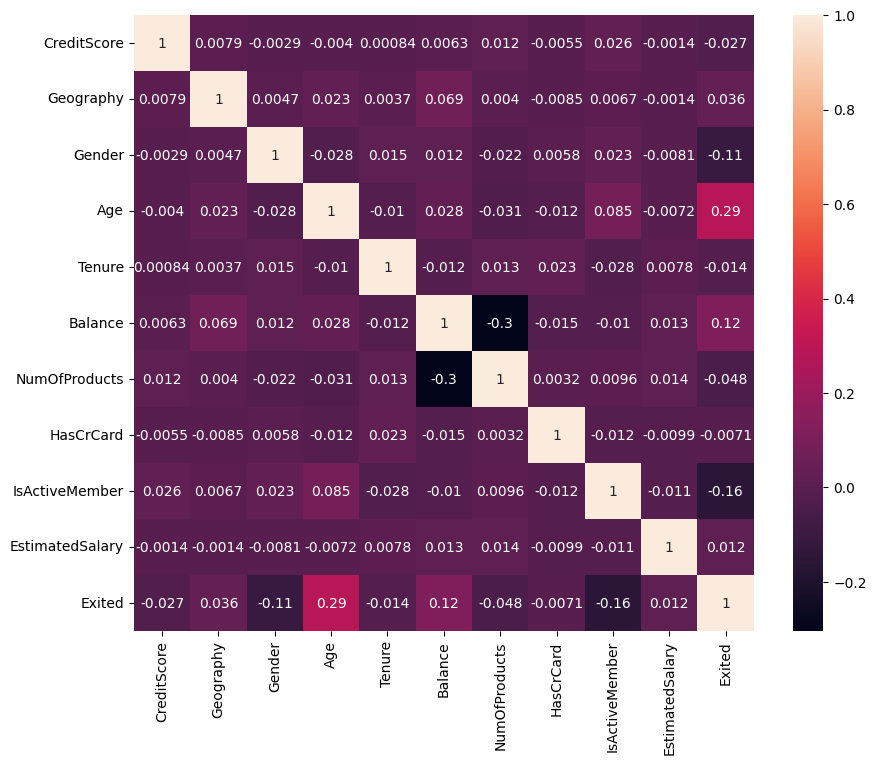

In [14]:
plt.figure(figsize=(10,8))
corr_df = data.corr()
sns.heatmap(corr_df,annot=True)

In [15]:
def violin(col):
    fig = px.violin(data, y=col, x="Exited", color="Exited", box=True)
    return fig.show()

def kde_plot(feature):
    grid = sns.FacetGrid(data, hue="Exited",aspect=2)
    grid.map(sns.kdeplot, feature)
    grid.add_legend()

In [16]:
violin('Age')

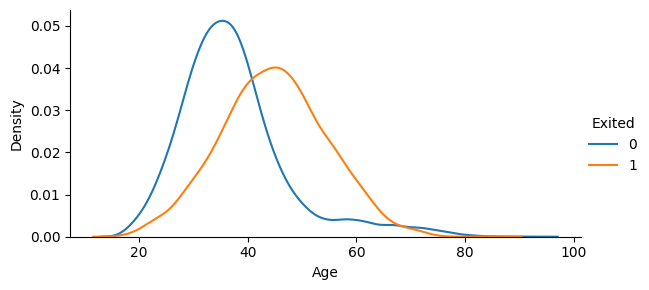

In [17]:
kde_plot('Age')

In [18]:
ind_col = [col for col in data.columns if col != 'Exited']
dep_col = 'Exited'

In [19]:
X = data[ind_col]
y = data[dep_col]

In [20]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


In [21]:
columns_to_normalize = ['CreditScore', 'Age', 'Balance','EstimatedSalary']

In [22]:
for column in columns_to_normalize:
    X[column] = (X[column] - X[column].mean()) / X[column].std()

<ipython-input-22-05855bd231c6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.326205,0,0,0.293503,2,-1.225786,1,1,1,0.021885
1,-0.440014,2,0,0.198154,1,0.117344,1,0,1,0.216523
2,-1.536717,0,0,0.293503,8,1.332987,3,1,0,0.240675
3,0.501496,0,0,0.007456,1,-1.225786,2,0,0,-0.108912
4,2.063781,2,0,0.388852,2,0.785689,1,1,1,-0.365258


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=0)

In [25]:
print(X_train.shape)
print(X_test.shape)

(8000, 10)
(2000, 10)


In [26]:
## Hyper Parameter Optimization with respect to XGBoost

XGBoost_params={
 "learning_rate"    : [0.05, 0.20, 0.25 ] ,
 "max_depth"        : [ 5, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.7 ]

}

## Hyper Parameter Optimization with respect to Random Forest
RF_params = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at every split
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

## Hyper Parameter Optimization with respect to Decision Tree
DT_params = {
    'criterion': ['gini', 'entropy','log_loss'],  # Measure of impurity
    'splitter': ['best', 'random'],  # Strategy to choose the split at each node
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider at every split
}

In [27]:
# XGBoost
xgboost = XGBClassifier()

# Random Forest
random_forest = RandomForestClassifier()

# Decision Tree
decision_tree = DecisionTreeClassifier()

In [28]:
# RandomizedSearchCV for XGBoost
XGBoost_random_search = RandomizedSearchCV(xgboost,param_distributions=XGBoost_params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
XGBoost_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.4],
                                        'learning_rate': [0.05, 0.2, 0.25],
                                        'max_depth': [5, 8, 10, 12],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [29]:
# RandomizedSearchCV for Random Forest
RF_random_search = RandomizedSearchCV(random_forest, param_distributions=RF_params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
RF_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   scoring='roc_auc', verbose=3)

In [30]:
# RandomizedSearchCV for Decision Tree
DT_random_search = RandomizedSearchCV(decision_tree, param_distributions=DT_params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
DT_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   scoring='roc_auc', verbose=3)

In [31]:
# Print the best parameters for each model
print("Best Parameters for XGBoost:")
print(XGBoost_random_search.best_params_)

print("\nBest Parameters for Random Forest:")
print(RF_random_search.best_params_)

print("\nBest Parameters for Decision Tree:")
print(DT_random_search.best_params_)

Best Parameters for XGBoost:
{'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}

Best Parameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}

Best Parameters for Decision Tree:
{'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'criterion': 'log_loss'}


In [32]:
# Define final XGBoost Classifier
xgboost_classifier = XGBClassifier(min_child_weight = 1, max_depth = 8, learning_rate = 0.05, gamma = 0.0, colsample_bytree  = 0.7)

# Define final Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 2, max_features = 'log2', max_depth = None, bootstrap = True)

# Define final Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(splitter =  'random', min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 10, criterion = 'log_loss')

In [33]:
# Train XGBoost Classifier
xgboost_classifier.fit(X_train, y_train)

# Train Random Forest Classifier
rf_classifier.fit(X_train, y_train)

# Train Decision Tree Classifier
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='log_loss', max_depth=10, splitter='random')

In [34]:
xgboost_pred = xgboost_classifier.predict(X_test)
rf_pred = rf_classifier.predict(X_test)
dt_pred = dt_classifier.predict(X_test)

In [35]:
# Confusion Matrix for XGBoost
confusion_xgboost = confusion_matrix(y_test, xgboost_pred)
print('Confusion Matrix for XGBoost:')
print(confusion_xgboost)

# Confusion Matrix for Random Forest
confusion_rf = confusion_matrix(y_test, rf_pred)
print('\nConfusion Matrix for Random Forest:')
print(confusion_rf)

# Confusion Matrix for Decision Tree
confusion_dt = confusion_matrix(y_test, dt_pred)
print('\nConfusion Matrix for Decision Tree:')
print(confusion_dt)

Confusion Matrix for XGBoost:
[[1521   74]
 [ 202  203]]

Confusion Matrix for Random Forest:
[[1529   66]
 [ 207  198]]

Confusion Matrix for Decision Tree:
[[1503   92]
 [ 214  191]]


In [36]:
# Accuracy of XGBoost
xgboost_accuracy = accuracy_score(y_test, xgboost_pred)
print("Accuracy of XGBoost:")
print(xgboost_accuracy)

# Accuracy of Random Forest
RF_accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy of Random Forest:")
print(RF_accuracy)

# Accuracy of Decision Tree
DT_accuracy = accuracy_score(y_test, dt_pred)
print("Accuracy of Decision Tree:")
print(DT_accuracy)

Accuracy of XGBoost:
0.862
Accuracy of Random Forest:
0.8635
Accuracy of Decision Tree:
0.847


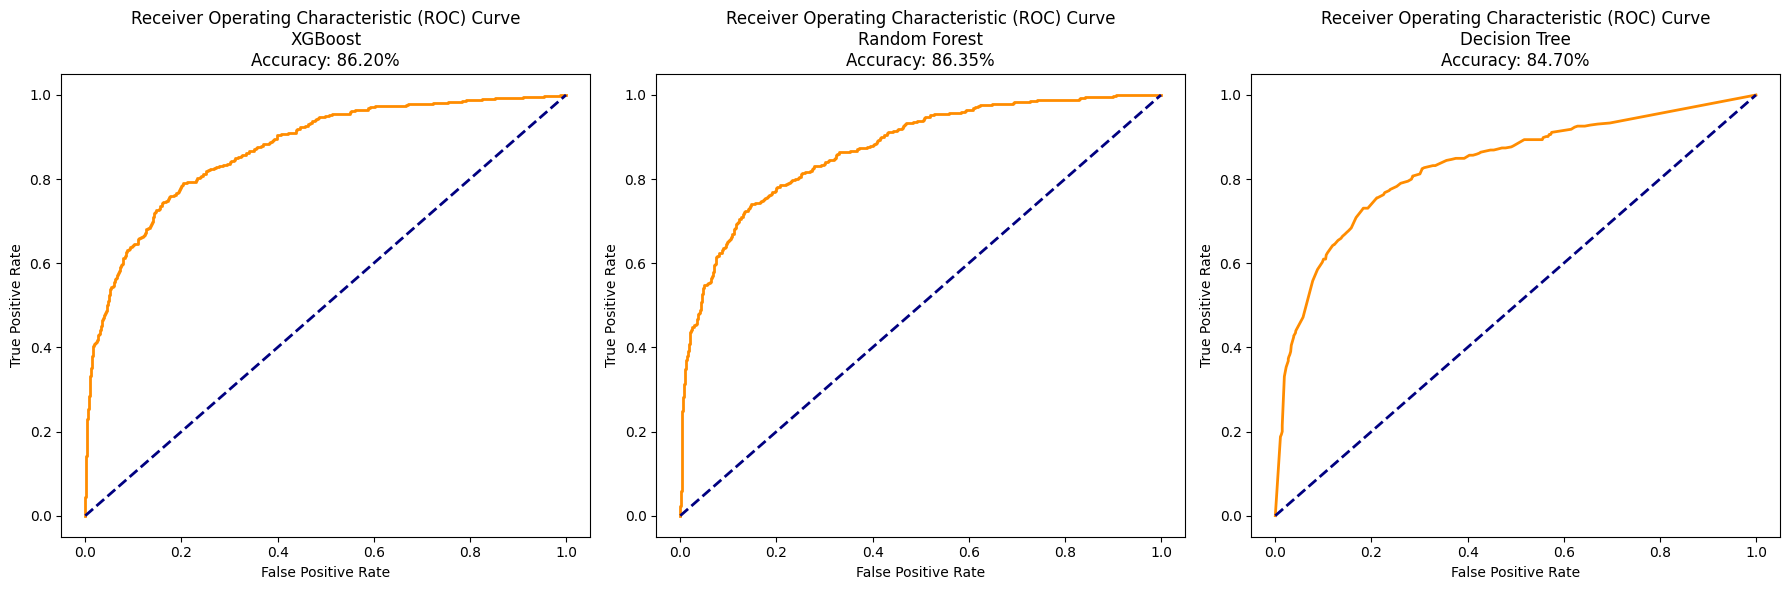

In [37]:
# subplot

# XGBoost
y_prob_xgb = xgboost_classifier.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# RandomForestClassifier
y_prob_rf = rf_classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# RandomForestClassifier
y_prob_dt = dt_classifier.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Create a subplot with 1 row and 3 columns
plt.figure(figsize=(18, 6))


# Plot for XGBoost
plt.subplot(1, 3, 1)
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nXGBoost\nAccuracy: {:.2f}%'.format(xgboost_accuracy * 100))

# Plot for RandomForestClassifier
plt.subplot(1, 3, 2)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nRandom Forest\nAccuracy: {:.2f}%'.format(RF_accuracy * 100))

# Plot for Decision Tree
plt.subplot(1, 3, 3)
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_dt))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nDecision Tree\nAccuracy: {:.2f}%'.format(DT_accuracy * 100))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()